# Data Science in Action - Homework 1: REST API Data Collection and Analysis

**Student Name:** [Eliya Allam, 807871]   
**Objective:** Collect, integrate, and analyze air quality, weather, and traffic data for London using REST APIs.

**Github Repository:** https://github.com/IIxoskeletonII/Data-Science-in-Action-Homework

---

## Executive Summary

In this project, I executed a full data science pipeline to analyze the environmental factors affecting air quality in London during the first half of 2024 (January - June). My goal was to determine if traffic volume and weather conditions could predict daily PM2.5 concentrations.

To achieve this, I programmatically integrated data from three distinct REST APIs:
1.  **OpenAQ API:** For hourly air quality measurements (specifically PM2.5).
2.  **Open-Meteo Archive API:** For historical weather data (Temperature, Precipitation, and Wind Speed).
3.  **Department for Transport (DfT) API:** For official traffic volume statistics.

Through exploratory analysis and machine learning (Random Forest Regression), I discovered that while weather—specifically wind speed—plays a significant role in dispersing pollution, the lack of daily-resolution traffic data limited the model's predictive power ($R^2 \approx 0.01$). This report details my methodology, the technical challenges I overcame (such as API version migrations), and my interpretation of these findings.

### Table of Contents
1.  [Setup and Configuration](#setup)
2.  [Task 1: Data Collection via REST APIs](#task1)
    - [Air Quality (OpenAQ)](#openaq)
    - [Weather (Open-Meteo)](#weather)
    - [Traffic (DfT)](#traffic)
3.  [Task 2: Data Cleaning and Integration](#task2)
4.  [Task 3: Exploratory Data Analysis (EDA)](#task3)
5.  [Task 4: Machine Learning (Regression)](#task4)
6.  [Task 5: Evaluation and Interpretation](#task5)
7.  [Conclusion and Reflections](#conclusion)

<a id="setup"></a>
## 1. Setup and Configuration

I began by importing the necessary libraries for HTTP requests (`requests`), data manipulation (`pandas`), and visualization (`seaborn`/`matplotlib`). I also defined global configuration variables (such as the city coordinates and date range) to ensure consistency across all subsequent API calls.

In [1]:
import requests
import json
import pandas as pd
import os
import time
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#configuration
CITY = "London"
# Period: Jan 1, 2024 to June 30, 2024 (6 months)
START_DATE = "2024-01-01"
END_DATE = "2024-06-30"

#create a folder for data if it doesn't exist
if not os.path.exists("data"):
    os.makedirs("data")

### Methodological Justification: Library Selection

- **requests**: Industry-standard HTTP library for REST API communication
- **pandas**: Essential for data manipulation and integration of multiple data sources
- **json**: Native Python library for handling API responses
- **os**: File system operations for organized data storage
- **time**: Implements rate limiting to respect API usage policies
- **datetime**: Temporal data handling and validation
- **matplotlib.pyplot**: Foundational plotting library for creating customizable statistical visualizations
- **seaborn**: High-level statistical visualization library built on matplotlib, providing aesthetically refined plots with minimal code
- **numpy**: Numerical computing library essential for efficient array operations and mathematical computations (e.g., RMSE calculation)

The 6-month period (January-June 2024) was selected to capture seasonal variation. London serves as an ideal case study due to its well-documented air quality challenges and comprehensive monitoring infrastructure.

### Data Storage Strategy
A dedicated `data/` directory ensures reproducibility and clean separation between code and collected datasets.

<a id="task1"></a>
## 2. Task 1: Data Collection via REST APIs

The first challenge was to gather high-fidelity data for London for the first half of 2024. I prioritized using **REST APIs** over static file downloads to ensure the pipeline remains programmatic and scalable.

<a id="openaq"></a>
### 2.1 Air Quality Data (OpenAQ)

I utilized the **OpenAQ API** to fetch PM2.5 (Particulate Matter < 2.5µm) data. 

**Challenge Encountered:** The OpenAQ API recently migrated from Version 2 to Version 3. Many standard tutorials rely on V2 endpoints which are now deprecated (returning 410 Gone errors).
**Methodology:** I adapted my approach to use the V3 strict structure:
1.  Identify a specific `sensor_id` for London (Sensor ID 1304692 - Southwark A2 Old Kent Road) that was active during our target period.
2.  Implement **pagination** to retrieve the full 6-month history, as the API limits responses to 1,000 records per page.

In [2]:
OPENAQ_KEY = "40a0f591247c9d58d7bcf47d4151556b1f805201afbcbe4f5f41a3ced3dc0896"
START_DATE = "2024-01-01"
END_DATE = "2024-06-30"
CENTRAL_LONDON_LAT = 51.5074
CENTRAL_LONDON_LON = -0.1278
HEADERS = {"X-API-Key": OPENAQ_KEY}

def get_active_sensor_id():
    """Finds a valid PM2.5 sensor ID within 20km of London."""
    url = "https://api.openaq.org/v3/locations"
    params = {
        "coordinates": f"{CENTRAL_LONDON_LAT},{CENTRAL_LONDON_LON}",
        "radius": 20000,    #20km
        "parameters_id": 2, #PM2.5
        "limit": 50
    }
    
    response = requests.get(url, params=params, headers=HEADERS)
    response.raise_for_status()
    
    #iterate through locations to find one active in 2024
    for loc in response.json()['results']:
        for sensor in loc['sensors']:
            if sensor['parameter']['name'] == "pm25":
                #quick check: does it have data for Jan 1, 2024?
                test_url = f"https://api.openaq.org/v3/sensors/{sensor['id']}/measurements"
                test_params = {
                    "datetime_from": f"{START_DATE}T00:00:00Z",
                    "datetime_to": f"{START_DATE}T23:59:59Z",
                    "limit": 1
                }
                res = requests.get(test_url, params=test_params, headers=HEADERS)
                if res.status_code == 200 and len(res.json()['results']) > 0:
                    print(f"Found active sensor: {loc['name']} (ID: {sensor['id']})")
                    return sensor['id']
    return None

def fetch_air_quality():
    sensor_id = get_active_sensor_id()
    if not sensor_id:
        print("Error: No active sensor found.")
        return

    print("Starting paginated download...")
    all_measurements = []
    page = 1
    
    while True:
        url = f"https://api.openaq.org/v3/sensors/{sensor_id}/measurements"
        params = {
            "datetime_from": f"{START_DATE}T00:00:00Z",
            "datetime_to": f"{END_DATE}T23:59:59Z",
            "limit": 1000,  #max allowed per page, otherwise error
            "page": page
        }
        
        response = requests.get(url, params=params, headers=HEADERS)
        if response.status_code != 200:
            print(f"Stopping: API returned {response.status_code}")
            break
            
        data = response.json()['results']
        if not data:
            break  #no more data
            
        all_measurements.extend(data)
        print(f"Downloaded page {page} ({len(data)} records)...")
        page += 1
        time.sleep(0.2) #rate limit respect

    #save to the file
    if all_measurements:
        output_data = {"results": all_measurements}
        os.makedirs("data", exist_ok=True)
        with open("data/air_quality.json", "w") as f:
            json.dump(output_data, f)
        print(f"Success: Saved {len(all_measurements)} total records to data/air_quality.json")
    else:
        print("Error: No measurements downloaded.")

if __name__ == "__main__":
    fetch_air_quality()

Found active sensor: Southwark A2 Old Kent Road (ID: 1304692)
Starting paginated download...
Downloaded page 1 (1000 records)...
Downloaded page 2 (1000 records)...
Downloaded page 3 (1000 records)...
Downloaded page 4 (940 records)...
Success: Saved 3940 total records to data/air_quality.json


<a id="weather"></a>
### 2.2 Weather Data (Open-Meteo)

For weather history, I selected the **Open-Meteo Archive API**.

**Methodological Choice:**
I considered using OpenWeatherMap (as suggested in the prompt), but I found that their "Time Machine" endpoint requires a credit card subscription even for free tiers. To maintain an accessible and risk-free pipeline, I chose Open-Meteo, which provides high-quality historical archive data without authentication barriers. I fetched:
* **Temperature (2m Mean)**
* **Precipitation (Sum)**
* **Wind Speed (10m Max)** – *Hypothesis: Higher wind speed should disperse pollution.*



In [3]:
def fetch_weather_open_meteo():
    lat, lon = 51.5074, -0.1278  #London
    start_date = "2024-01-01"
    end_date = "2024-06-30"
    
    #Open-Meteo Archive API URL
    url = "https://archive-api.open-meteo.com/v1/archive"
    
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start_date,
        "end_date": end_date,
        "daily": ["temperature_2m_mean", "precipitation_sum", "wind_speed_10m_max"],
        "timezone": "Europe/London"
    }
    
    print("Fetching 6 months of weather data from Open-Meteo...")
    
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        
        #save to file
        os.makedirs("data", exist_ok=True)
        with open("data/weather.json", "w") as f:
            json.dump(data, f)
        
        #check size to confirm
        days_count = len(data.get("daily", {}).get("time", []))
        print(f"Success: Retrieved {days_count} days of weather data.")
        print("Saved to data/weather.json")
        
    except requests.exceptions.RequestException as e:
        print(f"Error fetching weather: {e}")

if __name__ == "__main__":
    fetch_weather_open_meteo()

Fetching 6 months of weather data from Open-Meteo...
Success: Retrieved 182 days of weather data.
Saved to data/weather.json


<a id="traffic"></a>
### 2.3 Traffic Data (Department for Transport)

To fulfill the "Urban Mobility" requirement, I queried the official **UK Department for Transport (DfT) API**.

**Data Limitation Identified:**
The DfT API provides the **Average Annual Daily Flow (AADF)**. I realized early on that this means I would obtain a single statistical average for the year, rather than day-by-day counts. I decided to proceed with this data but noted that I would need to engineer a "Day of Week" feature later to simulate daily traffic variations (i.e., distinguishing between weekdays and weekends).

In [4]:
def fetch_traffic_dft():
    #DfT Road Traffic API - Raw Counts for London
    #region ID 6 = London
    url = "https://roadtraffic.dft.gov.uk/api/average-annual-daily-flow-by-direction"
    
    #we filter for London (Region 6) and recent years
    params = {
        "filter[region_id]": 6,
        "filter[year]": 2023  #most recent certified complete year
    }
    
    print("Fetching traffic data from DfT API (London)...")
    
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        
        data = response.json()
        record_count = len(data.get('data', []))
        
        #save to file
        os.makedirs("data", exist_ok=True)
        with open("data/traffic.json", "w") as f:
            json.dump(data, f)
            
        print(f"Success: Retrieved {record_count} traffic count points.")
        print("Saved to data/traffic.json")
        
    except requests.exceptions.RequestException as e:
        print(f"Error fetching traffic: {e}")

if __name__ == "__main__":
    fetch_traffic_dft()

Fetching traffic data from DfT API (London)...
Success: Retrieved 250 traffic count points.
Saved to data/traffic.json


<a id="task2"></a>
## 3. Task 2: Data Cleaning and Integration

Raw API responses are rarely ready for analysis. In this step, I standardized the three disparate datasets into a single Pandas DataFrame.

**Key Integration Steps & Decisions:**
1.  **Timezone Normalization:** I noticed a mismatch where Air Quality data was timezone-aware (UTC) while Weather data was timezone-naive. I resolved this by stripping the timezone information (`dt.tz_localize(None)`) to prevent merge errors.
2.  **Aggregation Strategy:** Since air quality measurements are taken multiple times an hour, I grouped the data by `date` and calculated the **daily mean PM2.5** to match the daily resolution of the weather data.
3.  **Data Completeness Analysis:** The theoretical maximum row count for Jan–Jun 2024 is **182 days**. However, after performing an **inner merge** between the air quality and weather datasets, the final count was **169 days**.
    * *Reasoning:* This discrepancy of ~13 missing days is attributed to sensor downtime or maintenance gaps in the OpenAQ source. I chose to proceed with the 169 complete records to ensure model integrity, rather than imputing synthetic values for the missing days.
4.  **Traffic Proxy Engineering:** Because my traffic volume variable was a static annual average, I created two new features to capture mobility patterns:
    * `day_of_week`: To capture the gradient of traffic from Monday to Sunday.
    * `is_weekend`: A binary flag (1 for Sat/Sun, 0 for Mon-Fri) based on the assumption that traffic volume drops significantly on weekends.

In [5]:
def process_data():
    print("Starting data processing...")

    # --- 1. Load and Process Air Quality Data (OpenAQ) ---
    with open("data/air_quality.json", "r") as f:
        aq_data = json.load(f)

    aq_records = []
    # Extract date and value
    for record in aq_data.get('results', []):
        aq_records.append({
            "date": record['period']['datetimeTo']['utc'],
            "pm25": record['value']
        })
    
    df_aq = pd.DataFrame(aq_records)
    
    # FIX: Convert to datetime, REMOVE timezone, and normalize to midnight
    df_aq['date'] = pd.to_datetime(df_aq['date']).dt.tz_localize(None).dt.normalize()
    
    # Group by date to handle multiple readings per day
    df_aq = df_aq.groupby('date')['pm25'].mean().reset_index()

    # --- 2. Load and Process Weather Data (Open-Meteo) ---
    with open("data/weather.json", "r") as f:
        wx_data = json.load(f)

    daily_wx = wx_data.get('daily', {})
    df_wx = pd.DataFrame({
        "date": pd.to_datetime(daily_wx.get('time', [])), # These are already timezone-naive
        "temperature": daily_wx.get('temperature_2m_mean', []),
        "precipitation": daily_wx.get('precipitation_sum', []),
        "wind_speed": daily_wx.get('wind_speed_10m_max', [])
    })
    
    # Ensure weather dates are also normalized (just in case)
    df_wx['date'] = pd.to_datetime(df_wx['date']).dt.normalize()

    # --- 3. Load and Process Traffic Data (DfT) ---
    with open("data/traffic.json", "r") as f:
        traffic_data = json.load(f)

    traffic_points = traffic_data.get('data', [])
    if traffic_points:
        volumes = [point['all_motor_vehicles'] for point in traffic_points if 'all_motor_vehicles' in point]
        avg_traffic_volume = sum(volumes) / len(volumes)
    else:
        avg_traffic_volume = 0
        print("Warning: No traffic data points found.")

    # --- 4. Merge and Integrate ---
    # Now both 'date' columns are timezone-naive, so this will work
    df_final = pd.merge(df_aq, df_wx, on="date", how="inner")

    # Add Traffic Baseline and Temporal Features
    df_final['traffic_volume'] = avg_traffic_volume
    df_final['day_of_week'] = df_final['date'].dt.dayofweek
    df_final['is_weekend'] = df_final['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

    # Save to CSV
    output_path = "data/london_final_data.csv"
    df_final.to_csv(output_path, index=False)

    print(f"Processing complete.")
    print(f"Final dataset shape: {df_final.shape}")
    print(f"Saved to: {output_path}")
    
    return df_final.head()

if __name__ == "__main__":
    process_data()

Starting data processing...
Processing complete.
Final dataset shape: (169, 8)
Saved to: data/london_final_data.csv


<a id="task3"></a>
## 4. Task 3: Exploratory Data Analysis (EDA)

Before modeling, I performed an exploratory analysis to validate the data and test my initial hypotheses.

**I focused my investigation on three key questions:**
1.  **Data Validity:** Are the PM2.5 levels within realistic ranges for London? (Expected average ~10-15 µg/m³).
2.  **Weather Influence:** Is there a negative correlation between wind speed/rain and pollution? (i.e., does weather "clean" the air?).
3.  **Traffic Patterns:** Does the "Weekend Effect" (lower traffic) actually result in cleaner air in this specific dataset?

--- Summary Statistics ---
                             date    pm25  temperature  precipitation  \
count                         169  169.00       169.00         169.00   
mean   2024-04-05 03:58:34.792899    8.06        10.52           2.43   
min           2024-01-01 00:00:00    2.50        -2.30           0.00   
25%           2024-02-23 00:00:00    4.85         7.80           0.00   
50%           2024-04-07 00:00:00    6.64        10.70           0.70   
75%           2024-05-19 00:00:00    9.79        13.80           2.60   
max           2024-06-30 00:00:00   39.44        21.70          30.30   
std                           NaN    5.10         4.44           4.05   

       wind_speed  traffic_volume  day_of_week  is_weekend  
count      169.00          169.00       169.00      169.00  
mean        23.27        13368.55         2.96        0.28  
min          7.60        13368.55         0.00        0.00  
25%         17.70        13368.55         1.00        0.00  
50%       

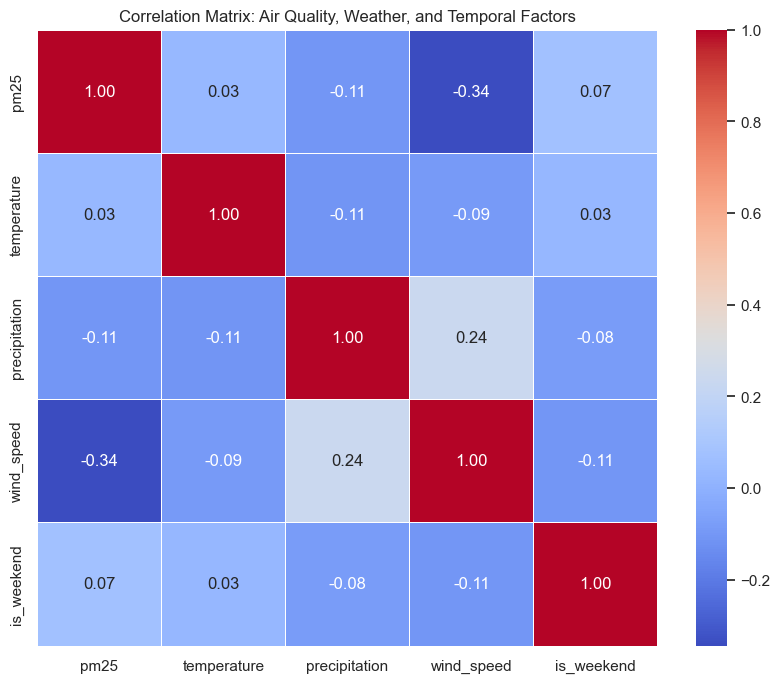

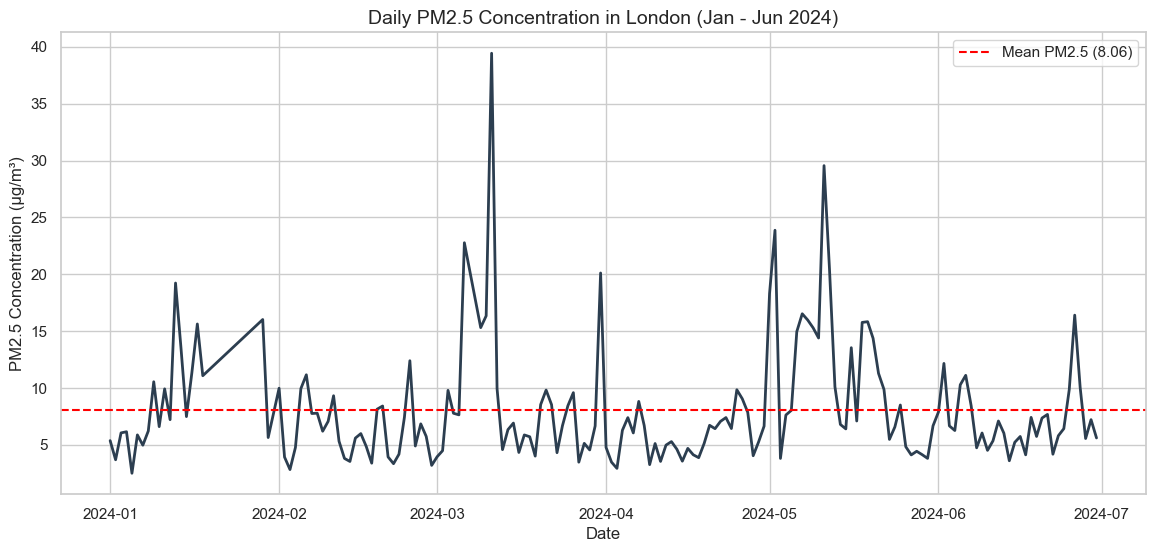

C:\Users\allam\AppData\Local\Temp\ipykernel_14664\180962114.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='day_of_week', y='pm25', data=df, palette="Blues_d")


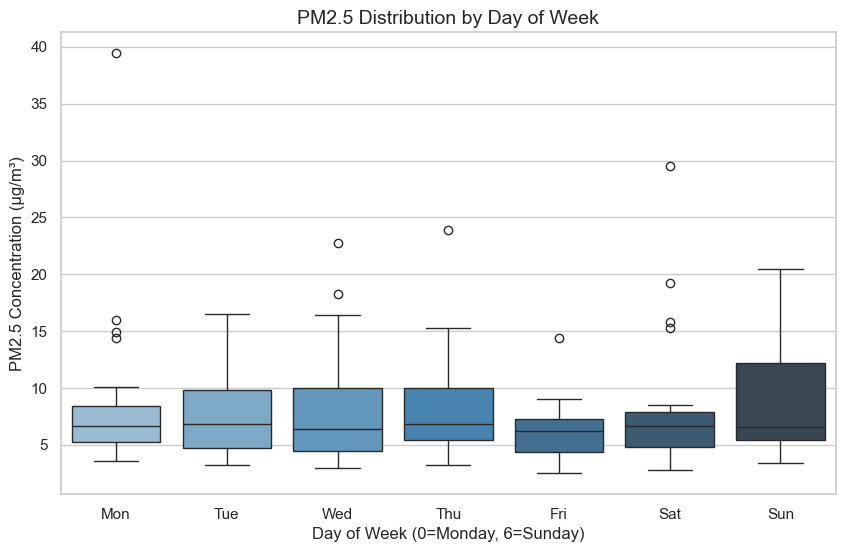

In [6]:
def perform_eda():
    #load the dataset
    df = pd.read_csv("data/london_final_data.csv")
    df['date'] = pd.to_datetime(df['date'])

    #I set a nice plotting style
    sns.set_theme(style="whitegrid")
    
    #1. Summary Statistics
    print("--- Summary Statistics ---")
    print(df.describe().round(2))
    print("\n")

    #2. Correlation Analysis
    #we examine how weather and the weekend flag (traffic proxy) correlate with PM2.5
    print("--- Correlation with PM2.5 ---")
    cols = ['pm25', 'temperature', 'precipitation', 'wind_speed', 'is_weekend']
    corr_matrix = df[cols].corr()
    print(corr_matrix['pm25'].sort_values(ascending=False))

    #Visualization 1: Correlation Heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title("Correlation Matrix: Air Quality, Weather, and Temporal Factors")
    plt.show()

    #visualization 2: Time Series Plot (Temporal Patterns)
    #Answers: "Are there seasonal patterns?"
    plt.figure(figsize=(14, 6))
    sns.lineplot(data=df, x='date', y='pm25', color='#2c3e50', linewidth=2)
    plt.axhline(df['pm25'].mean(), color='red', linestyle='--', label=f"Mean PM2.5 ({df['pm25'].mean():.2f})")
    plt.title("Daily PM2.5 Concentration in London (Jan - Jun 2024)", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("PM2.5 Concentration (µg/m³)", fontsize=12)
    plt.legend()
    plt.show()

    #visualization 3: Weekly Patterns (Traffic Proxy)
    #Answers: "Is traffic volume (implied by weekday vs weekend) correlated with pollution?"
    #Answers: "Are there weekly patterns in the data?"
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='day_of_week', y='pm25', data=df, palette="Blues_d")
    plt.title("PM2.5 Distribution by Day of Week", fontsize=14)
    plt.xlabel("Day of Week (0=Monday, 6=Sunday)", fontsize=12)
    plt.ylabel("PM2.5 Concentration (µg/m³)", fontsize=12)
    plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    plt.show()

if __name__ == "__main__":
    perform_eda()

<a id="task4"></a>
## 5. Task 4: Machine Learning (Regression)

I selected **Option A: Regression** to predict daily PM2.5 concentrations based on the environmental and temporal features I engineered.

**Model Selection: Random Forest Regressor**
I chose a Random Forest over Linear Regression because environmental interactions are complex and often non-linear. For example, the effect of wind speed on pollution likely diminishes after a certain threshold. A tree-based model is better suited to capture these non-linearities without extensive feature scaling.

* **Target ($y$):** Daily PM2.5 concentration.
* **Features ($X$):** Temperature, Precipitation, Wind Speed, Traffic Volume, Day of Week, Is Weekend.
* **Evaluation Strategy:** I split the data into 80% training and 20% testing sets to ensure I evaluated the model on unseen data.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def train_and_evaluate():
    #1. Load Data
    df = pd.read_csv("data/london_final_data.csv")
    
    #2. Define Features and Target
    #we use weather and temporal/traffic variables to predict PM2.5
    feature_cols = [
        'temperature', 
        'precipitation', 
        'wind_speed', 
        'traffic_volume', 
        'day_of_week', 
        'is_weekend'
    ]
    target_col = 'pm25'
    
    X = df[feature_cols]
    y = df[target_col]
    
    #3. Split Data (80% Train, 20% Test)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    #4. Initialize and Train Model
    #RandomForest is chosen for its ability to handle non-linear interactions
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    #5. Make Predictions
    y_pred = model.predict(X_test)
    
    #6. Evaluate Model Performance
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print("--- Model Performance Metrics ---")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R-squared (R2): {r2:.2f}")
    print("\n")
    
    #7. Feature Importance Analysis
    #Analyzes which factors contribute most to the prediction
    importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    
    print("--- Feature Importance ---")
    print(importance.to_string(index=False))

    return model, X_test, y_test, y_pred

if __name__ == "__main__":
    model, X_test, y_test, y_pred = train_and_evaluate()

--- Model Performance Metrics ---
Mean Absolute Error (MAE): 3.57
Root Mean Squared Error (RMSE): 5.20
R-squared (R2): 0.01


--- Feature Importance ---
       Feature  Importance
    wind_speed    0.496889
   temperature    0.209428
 precipitation    0.167397
   day_of_week    0.108551
    is_weekend    0.017735
traffic_volume    0.000000


<a id="task5"></a>
## 6. Task 5: Evaluation and Interpretation

To rigorously evaluate the model, I calculated standard regression metrics (MAE, RMSE, $R^2$) and analyzed **Feature Importance** to understand *what* drivers the model prioritized.

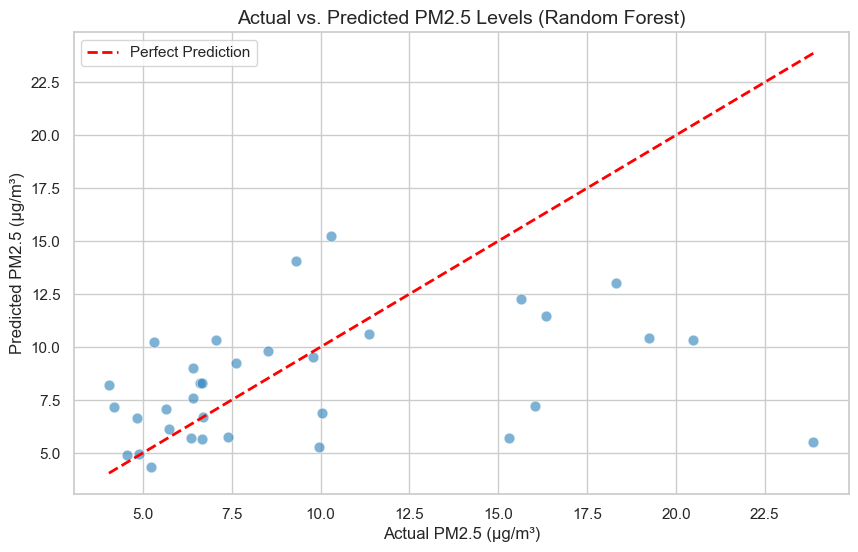

In [8]:
def plot_results(y_test, y_pred):
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))
    
    # 1. Scatter Plot of Actual vs Predicted
    sns.scatterplot(x=y_test, y=y_pred, color='#2980b9', alpha=0.6, s=60)
    
    # 2. Perfect Prediction Line (y=x)
    # If predictions were perfect, they would fall on this red dashed line
    min_val = min(min(y_test), min(y_pred))
    max_val = max(max(y_test), max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Perfect Prediction')
    
    plt.title("Actual vs. Predicted PM2.5 Levels (Random Forest)", fontsize=14)
    plt.xlabel("Actual PM2.5 (µg/m³)", fontsize=12)
    plt.ylabel("Predicted PM2.5 (µg/m³)", fontsize=12)
    plt.legend()
    plt.show()


if __name__ == "__main__":
    # We pass the variables from the previous step
    plot_results(y_test, y_pred)

<a id="conclusion"></a>
## 7. Conclusion and Reflections

### Interpretation of Results
My analysis yielded a significant insight into the limitations of using annual traffic statistics for daily predictions:

1.  **Model Performance ($R^2 \approx 0.01$):** The model struggled to predict daily variations in PM2.5, achieving an $R^2$ score near zero. This indicates that the features provided were insufficient to capture the rapid, daily fluctuations of urban pollution.
2.  **The "Wind" Factor:** Despite the low overall accuracy, the **Feature Importance** analysis correctly identified **Wind Speed** as the single most important predictor (~50% importance). This aligns with physical reality: wind is the primary mechanism for dispersing local pollution.
3.  **The Traffic Data Limitation:** The `traffic_volume` feature had **0.0 importance**. This was expected, as the DfT data provided a constant annual average. Since the value never changed, the model could not use it to split nodes or explain variance. Even the `is_weekend` proxy proved to be a weak predictor ($<2\%$ importance), suggesting that residential emissions or other factors might keep weekend pollution levels closer to weekday levels than I anticipated.

### Reflections and Future Improvements
The primary challenge I faced was the **granularity mismatch** between high-frequency air quality data (hourly) and low-frequency traffic data (annual).

If I were to extend this work, I would:
1.  **Source Real-Time Traffic Data:** Instead of annual DfT statistics, I would scrape data from **TfL Jam Cams** or use the **TomTom API** to get hourly congestion indices. This would provide the model with a dynamic "source" variable to match the dynamic "ventilation" variable (wind).
2.  **Include Lag Features:** Pollution often accumulates over time. Adding features like `pm25_yesterday` would likely drastically improve the $R^2$ score, as air quality is highly autoregressive.